<a href="https://colab.research.google.com/github/Sabya2/Malnutrition-EDA/blob/main/malnutrition_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler


# Inspiration

 * Was there a decline or rise in the number of malnutrition cases country-wise?
 * Which countries bear the greatest share of all forms of malnutrition?
 * % of stunted, overweight and wasted children under 5, by country income classification
 * Develop a GHI, and based on GHI explore the worst and best placed countries.

# Data

In [ ]:
country_wise_average = "/content/drive/MyDrive/Kaggle data/country-wise-average.csv"
malnutrition_estimates = "/content/drive/MyDrive/Kaggle data/malnutrition-estimates.csv"

df_country = pd.read_csv(country_wise_average)
df_country.head(10)

df_mal = pd.read_csv(malnutrition_estimates)
df_mal.head(2)


,Unnamed: 0,ISO code,Country,Survey Year,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,Notes,Report Author,Source,Short Source,U5 Population ('000s)
0,0,AFG,AFGHANISTAN,1997,1997,0,1.0,1.0,1.0,"4,846",NaN,18.2,6.5,53.2,44.9,Converted estimates,CIET International,Afghanistan 1997 multiple indicator baseline (...,MICS,3838.877
1,1,AFG,AFGHANISTAN,2004,2004,0,1.0,1.0,1.0,946,3.5,8.6,4.6,59.3,32.9,NaN,"Ministry of Public Health (Afghanistan), UNICE...",Summary report of the national nutrition surve...,NNS,4789.353


In [ ]:
# data information

print("country wise data", df_country.shape)
print('\ncountry unique in country data',len(df_country['Country'].unique()))
print('\n' ,list(df_country.columns))

print("\n\nMalnutrition data", df_mal.shape)
print('\ncountry unique malnutrition data',len(df_mal['Country'].unique()))
print('\n' ,list(df_mal.columns))

country wise data (152, 8)

country unique in country data 152

 ['Country', 'Income Classification', 'Severe Wasting', 'Wasting', 'Overweight', 'Stunting', 'Underweight', "U5 Population ('000s)"]


Malnutrition data (924, 20)

country unique malnutrition data 152

 ['Unnamed: 0', 'ISO code', 'Country', 'Survey Year', 'Year', 'Income Classification', 'LDC', 'LIFD', 'LLDC or SID2', 'Survey Sample (N)', 'Severe Wasting', 'Wasting', 'Overweight', 'Stunting', 'Underweight', 'Notes', 'Report Author', 'Source', 'Short Source', "U5 Population ('000s)"]



# Things to be updated sequentially 
* feature: sample size is string, convert to float/integer.
    * Nan is converetd into 0, so handle that later while using it 
* Remove from malnutrition data ['Unnamed: 0', 'ISO code', 'Survey Year', 'Notes'(no sense for now), 'Report Author', 'Source', 'Short Source',]
* Fill the missing data country specific 
    * within group missing data, either median or mean
    * if possible, use the correlation between sample syrvey if present and data, to fill the missing data. (linear relation)
* Based on country wise groups, and fill the missing values in the country wise data
* GHI calculation and use the rank to explore data
    * lack of mortality value so use the rest 
    * combine the severe wasting and wasting as one unit
* Income class is country specific or survey specific
    * if country specific, then get the the country specific daaset to work and different classes
    * If survey specific, see what happens
* EDA


# Data Clean

In [ ]:
# removing unwanted columns in malnutrition dataset
df_mal.drop(['Unnamed: 0', 'ISO code', 'Survey Year', 'Notes', 'Report Author', 'Source', 'Short Source'],inplace = True, axis = 1)

In [ ]:
# Converting survey sample to float/integer of malnutrition dataset

print(df_mal['Survey Sample (N)'].dtypes)
df_mal['Survey Sample (N)'].isnull().sum()

df_mal['Survey Sample (N)'] = df_mal['Survey Sample (N)'].str.replace(",","")
# df_mal['Survey Sample (N)'].loc[471]
df_mal['Survey Sample (N)'] = df_mal['Survey Sample (N)'].str.replace("-","0")

df_mal['Survey Sample (N)'] = df_mal['Survey Sample (N)'].fillna(0)
df_mal['Survey Sample (N)'] = pd.to_numeric(df_mal['Survey Sample (N)'])

# Converted survey sample to float/integer
print(df_mal['Survey Sample (N)'].dtypes)
df_mal['Survey Sample (N)'].isnull().sum()

object
int64


0

## Handling Missing Data for malnutrition dataset
Approach : Country wise the missing values are imputed. Running a loop for each column, grouped by country names and imputed

In [ ]:
null = df_mal.isnull().sum()
print(null[null>0])
# or print(df_mal.isnull().sum()[df_mal.isnull().sum() > 0])

Severe Wasting    228
Wasting            47
Overweight        136
Stunting           37
Underweight        22
dtype: int64


In [ ]:
cols = list(["Severe Wasting", "Wasting", "Overweight", "Stunting","Underweight"])
df_mal[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Severe Wasting,696.0,2.191523,1.912586,0.0,0.800,1.6,2.9,12.9
Wasting,877.0,6.955644,5.039402,0.0,2.900,5.9,9.7,25.3
Overweight,788.0,6.434772,4.638849,0.0,2.900,5.5,8.7,30.1
Stunting,887.0,29.063134,15.834657,0.0,16.650,29.2,40.2,73.6
Underweight,902.0,15.841242,12.509643,0.0,4.925,13.4,23.1,66.8


In [ ]:
# Filling missing values

cols = ["Severe Wasting", "Wasting", "Overweight", "Stunting","Underweight"]
     
for x in cols:
    df_mal[x] = df_mal.groupby('Country')[x].transform(lambda grp: grp.fillna(np.mean(grp)))
    df_mal[x].fillna(df_mal[x].mean(), inplace=True)
# there are two steps, since for some uknown reason groupb+transform couldn't fill all the data
# thus the general fillna with mean, to maximise the closeness to the original data

df_mal[cols].describe().T
# to check the deviation from the original data

,count,mean,std,min,25%,50%,75%,max
Severe Wasting,924.0,2.209957,1.793310,0.0,0.900,1.9,2.803409,12.9
Wasting,924.0,6.956906,5.009191,0.0,2.900,5.9,9.800000,25.3
Overweight,924.0,6.396381,4.484447,0.0,3.000,5.7,8.600000,30.1
Stunting,924.0,28.900356,15.784480,0.0,16.475,29.2,40.000000,73.6
Underweight,924.0,15.700069,12.465795,0.0,4.875,13.3,22.800000,66.8


In [ ]:
df_country.isnull().sum()

Country                   0
Income Classification     0
Severe Wasting           12
Wasting                   2
Overweight                3
Stunting                  1
Underweight               2
U5 Population ('000s)     0
dtype: int64

## Handling missing data for country dataset

Appproach: Impute with the mean data from the malnutrition dataset to get good low error results. 

In [ ]:
country_grp = df_mal.groupby('Country')
# country_grp.first()

In [ ]:
# Functions for filling the null values
# takes value from the df_mal and fill in df_country

def null_fill(col_name):
    
    null_index = df_country[df_country[col_name].isnull()].index.tolist()
    
    for x_null in null_index:
        # print(x_null)
        cn = df_country["Country"].iloc[x_null]
        # print(cn)
        cn_grp = country_grp.get_group(cn)
        # print(cn_grp, "\n\n\n")
        cn_grp_mean = cn_grp[col_name].mean()
        # print(cn_grp_mean, "\n\n\n")
        df_country.loc[x_null,col_name] = cn_grp_mean

In [ ]:
# funcion caling and filling the data
null_fill("Severe Wasting")
null_fill('Wasting')
null_fill('Overweight')
null_fill('Stunting')
null_fill('Underweight')


# Creating GHI (Globall Hungr Index)


*   work on country specific dataset
*   variables are ('Severe Wasting' + 'Wasting'), 'Stunting', 'Underweight' --- 33.33% weightage to each
*  Scaling of the above variables
* calculate ghi (high ghi-bad state and low ghi-good state)






In [ ]:
df_country.columns


Index(['Country', 'Income Classification', 'Severe Wasting', 'Wasting',
       'Overweight', 'Stunting', 'Underweight', 'U5 Population ('000s)'],
      dtype='object')

In [ ]:
col = ['Country', "Severe Wasting",'Wasting', 'Stunting', 'Underweight' ]

c_ghi = df_country[col].copy() # without copy, the new dataframe is linked to the original dataframe creating error
c_ghi.isnull().sum()

Country           0
Severe Wasting    0
Wasting           0
Stunting          0
Underweight       0
dtype: int64

In [ ]:
# combine severe wasting and wasting
c_ghi['severe_wasting'] = c_ghi["Severe Wasting"] + c_ghi['Wasting']

In [ ]:
scaler = MinMaxScaler()
c_ghi[["scaled_wasting", "scaled_stunting", "scaled_underweight"]] = scaler.fit_transform(c_ghi[['severe_wasting','Stunting', 'Underweight']])

In [ ]:
#ri.drop('county_name',axis='columns', inplace=True)
c_ghi.drop(columns = ["Severe Wasting", 'Wasting', 'Stunting', 'Underweight', 'severe_wasting'], inplace = True)
c_ghi

,Country,scaled_wasting,scaled_stunting,scaled_underweight
0,AFGHANISTAN,0.381835,0.826413,0.655776
1,ALBANIA,0.337660,0.409187,0.164621
2,ALGERIA,0.247538,0.328117,0.156885
3,ANGOLA,0.266286,0.735571,0.509025
4,ARGENTINA,0.067047,0.159452,0.054152
...,...,...,...,...
147,VENEZUELA (BOLIVARIAN REPUBLIC OF),0.186684,0.281928,0.089737
148,VIET NAM,0.313642,0.599341,0.494257
149,YEMEN,0.586101,0.899293,0.816297
150,ZAMBIA,0.216426,0.832818,0.385250


In [ ]:
# calculating GHI
c_ghi['ghi'] = (c_ghi['scaled_wasting'] + c_ghi['scaled_stunting'] + c_ghi['scaled_underweight'])/3*100
c_ghi['ghi']= round(c_ghi['ghi'])
c_ghi

,Country,scaled_wasting,scaled_stunting,scaled_underweight,ghi
0,AFGHANISTAN,0.381835,0.826413,0.655776,62.0
1,ALBANIA,0.337660,0.409187,0.164621,30.0
2,ALGERIA,0.247538,0.328117,0.156885,24.0
3,ANGOLA,0.266286,0.735571,0.509025,50.0
4,ARGENTINA,0.067047,0.159452,0.054152,9.0
...,...,...,...,...,...
147,VENEZUELA (BOLIVARIAN REPUBLIC OF),0.186684,0.281928,0.089737,19.0
148,VIET NAM,0.313642,0.599341,0.494257,47.0
149,YEMEN,0.586101,0.899293,0.816297,77.0
150,ZAMBIA,0.216426,0.832818,0.385250,48.0


In [ ]:
c_ghi.set_index('ghi', inplace = True)
c_ghi.sort_index(inplace = True)
c_ghi

,Country,scaled_wasting,scaled_stunting,scaled_underweight
ghi,,,,
0.0,AUSTRALIA,0.000000,0.000000,0.000000
2.0,GERMANY,0.021398,0.008834,0.015162
2.0,UNITED STATES OF AMERICA (THE),0.015814,0.033821,0.016895
3.0,REPUBLIC OF KOREA (THE),0.034237,0.026502,0.015162
4.0,CHILE,0.076366,0.043345,0.014007
...,...,...,...,...
76.0,ERITREA,0.548740,0.922703,0.811191
77.0,YEMEN,0.586101,0.899293,0.816297
81.0,BANGLADESH,0.495040,0.940445,1.000000


In [ ]:
print(c_ghi['Country'].head(3).to_list())
print(c_ghi['Country'].tail(3).to_list())

['AUSTRALIA', 'GERMANY', 'UNITED STATES OF AMERICA (THE)']
['BANGLADESH', 'TIMOR-LESTE', 'INDIA']


# Exploration of 
* ['AUSTRALIA', 'GERMANY', 'UNITED STATES OF AMERICA (THE)']
* ['BANGLADESH', 'TIMOR-LESTE', 'INDIA']

Ideas: 
* Expore India and Australia
* over year changes with parameter
* Income group changes with parameters
* explore: Low Income Food Deficient (LIFD)(true=1,
false=0) , Least Developed Countries (LDC)(true=1, false=0)



## Grouping of the malnutrition data based on country

In [ ]:
# Unwanted columns have been removed already
df_mal

In [ ]:
india = df_mal.groupby(['Country']).get_group('INDIA')
india.reset_index()

australia = df_mal.groupby(['Country']).get_group('AUSTRALIA')
australia.reset_index()

,index,Country,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
0,28,AUSTRALIA,1995,3,0.0,0.0,0.0,1036810,0.0,0.0,7.9,0.0,0.0,1297.817
1,29,AUSTRALIA,2007,3,0.0,0.0,0.0,1007,0.0,0.0,7.7,2.0,0.2,1328.020
2,30,AUSTRALIA,2014,3,0.0,0.0,0.0,0,0.0,0.0,17.9,1.0,0.1,1551.012
3,31,AUSTRALIA,2017,3,0.0,0.0,0.0,0,0.0,0.0,22.0,1.0,0.1,1595.449


In [ ]:
india

,Country,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
340,INDIA,1989,1,0.0,1.0,0.0,13548,6.116667,20.3,2.933333,62.7,55.5,121226.737
341,INDIA,1992,1,0.0,1.0,0.0,2948,6.116667,20.0,2.933333,61.9,52.8,123144.679
342,INDIA,1993,1,0.0,1.0,0.0,38418,7.000000,19.9,2.900000,57.7,51.2,123695.199
343,INDIA,1997,1,0.0,1.0,0.0,22959,6.116667,18.4,5.900000,45.9,38.4,126145.646
344,INDIA,1999,1,0.0,1.0,0.0,26403,5.700000,17.1,2.900000,54.2,46.3,127300.714
345,INDIA,2006,1,0.0,1.0,0.0,49149,6.800000,20.0,1.900000,47.8,43.5,129784.914
346,INDIA,2014,1,0.0,1.0,0.0,91273,4.600000,15.1,2.933333,38.7,29.4,120676.724
347,INDIA,2015,1,0.0,1.0,0.0,230488,7.700000,20.8,2.400000,37.9,36.3,118983.308
348,INDIA,2017,1,0.0,1.0,0.0,0,4.900000,17.3,1.600000,34.7,33.4,116172.498


## over the year changes in parameters

fig = plt.figure(figsize =(10,5) )
fig.suptitle('Parameter Changes over the Years')

* subplot #1
plt.subplot(151)
plt.title('Wasting')
sns.barplot(x="Year", y="Severe Wasting", data=india)

* subplot #2
plt.subplot(152)
plt.title('Wasting')
sns.barplot(x="Year", y="Wasting", data=india)



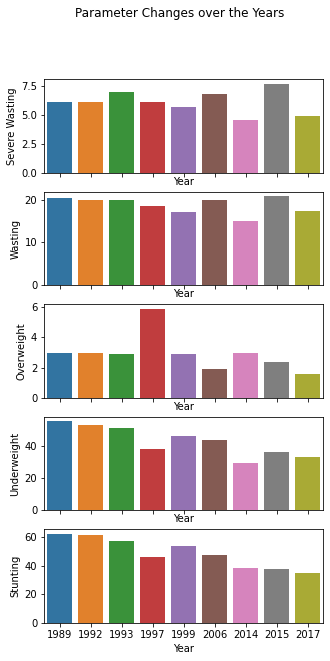

In [ ]:
fig, axes = plt.subplots(5,1, figsize=(5, 10), sharex = True)
fig.suptitle('Parameter Changes over the Years')

# Severe Wasting
sns.barplot(ax = axes[0], x="Year", y="Severe Wasting", data=india)

# Wasting
sns.barplot(ax = axes[1], x="Year", y="Wasting", data=india)

# Overweight
sns.barplot(ax = axes[2], x="Year", y="Overweight", data=india)

# Underweight
sns.barplot(ax = axes[3], x="Year", y="Underweight", data=india)

# Stunting
sns.barplot(ax = axes[4], x="Year", y="Stunting", data=india)

# combining all together
# india.plot(x="Year", y=["Severe Wasting",	"Wasting", "Overweight",	"Stunting",	"Underweight"], kind="bar", figsize =(8,5), title = "Parameter Changes over the Years")

information: 
* decrease in stunting
* no significant change in rest of the parameters
* overweight is too less throughout the years

# Comparison of India and Australia (worst and best) 

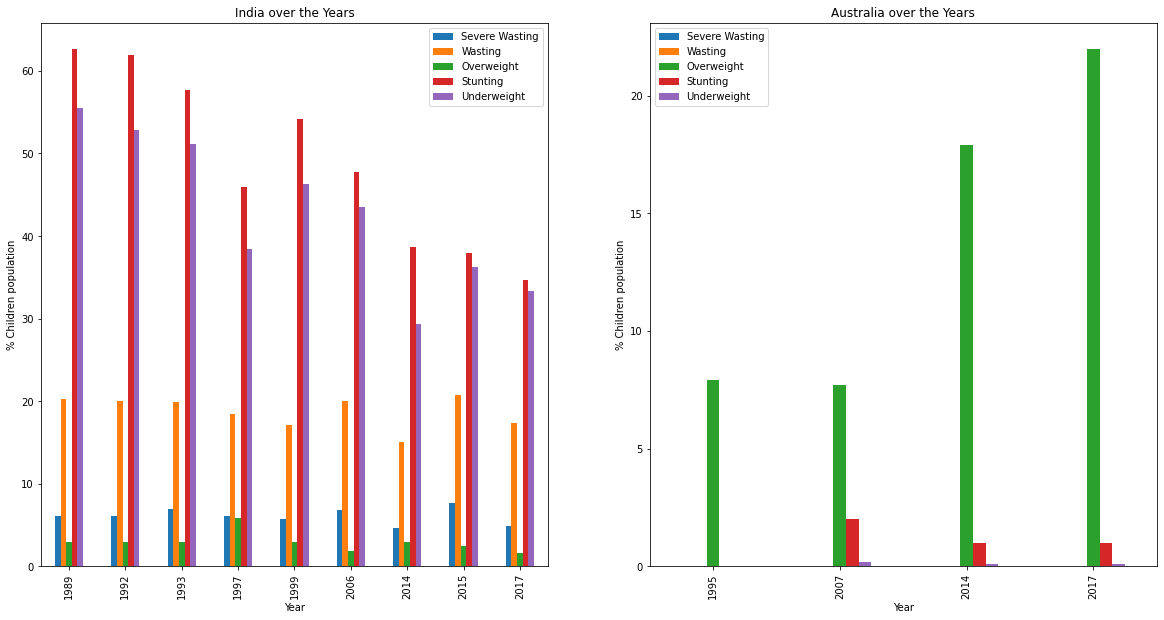

In [ ]:
figure, axes = plt.subplots(1,2)
india.plot(ax = axes[0], x="Year", y=["Severe Wasting",	"Wasting", "Overweight",	"Stunting",	"Underweight"], 
           ylabel = "% Children population", kind="bar", figsize =(20,10), title = "India over the Years")

australia.plot(ax = axes[1] ,x="Year", y=["Severe Wasting",	"Wasting", "Overweight",	"Stunting",	"Underweight"], 
               ylabel = "% Children population", kind="bar", figsize =(20,10), title = "Australia over the Years")